In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import os as os
import sys as sys
import glob as glob
import re as re
import numpy as np
import shutil as shutil

import paprika
print(paprika.__version__)

from paprika.amber import Simulation
from paprika import analysis
from paprika.restraints import DAT_restraint

import pytraj as pt
import parmed as pmd

2018-04-23_16:10:29_-0700-e34840d-0.0.3


In [2]:
import logging
from importlib import reload
reload(logging)

logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %I:%M:%S %p',
                    level=logging.DEBUG)
logging.info('Started logging...')

2018-04-25 07:24:18 PM Started logging...


In [3]:
dummy_anchors = [':3', ':4', ':5']
host_anchors  = [':1@C26', ':1@C18', ':1@C8']

In [4]:
guest_anchors = [':2@C1', ':2@C3']

In [5]:
attach_string = '0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 ' \
                '18.10 24.40 37.00 49.60 74.80 100.00'
attach_fractions = [float(i) / 100 for i in attach_string.split()]

pull_string = '0.00 0.40 0.80 1.20 1.60 2.00 2.40 2.80 3.20 3.60 4.00 ' \
              '4.40 4.80 5.20 5.60 6.00 6.40 6.80 7.20 7.60 8.00 8.40 ' \
              '8.80 9.20 9.60 10.00 10.40 10.80 11.20 11.60 12.00 12.40 ' \
              '12.80 13.20 13.60 14.00 14.40 14.80 15.20 15.60 16.00 16.40 ' \
              '16.80 17.20 17.60 18.00'

windows = [len(attach_fractions), len(pull_string.split()), 0]

In [6]:
g3_complexes = glob.glob('./OA-G3*')

In [7]:
ntwprt = 204

In [8]:
paths = glob.glob(os.path.normpath(os.path.join('./OA-G3-0', 'AMBER', 'APR', 'windows', '*')))

In [9]:
window_list = [os.path.basename(i) for i in paths]
phase_dict = {'a': 'attach', 'p': 'pull', 'r': 'release'}

<IPython.core.display.Javascript object>


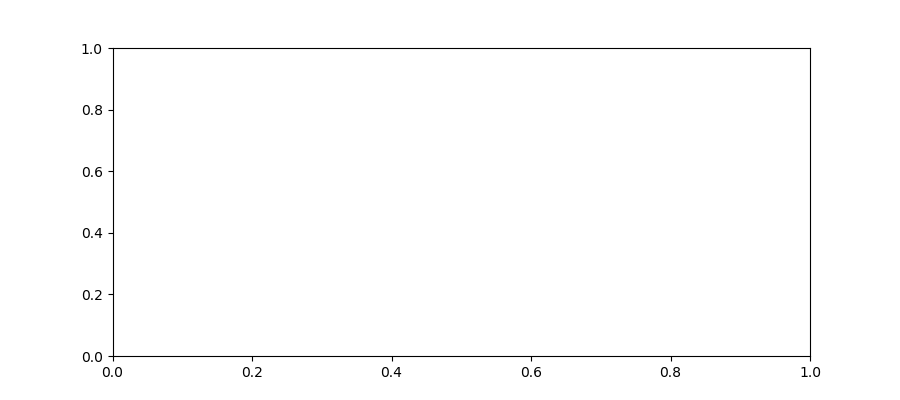

In [10]:
fig,axs = plt.subplots(figsize=(9,4))
axis = [4.0, 26.0, 0.0, 2.5]
zorder = len(window_list) + 2

# Converence threshold, kcal/mol (probably need separate for attach vs. pull)
convergence_thresh = {'attach': 0.006, 'pull': 0.03}
# Simulation steps per iteration
itr_nstlim = 500000

In [ ]:
for complx in [g3_complexes[4]]:
    
    
    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]
    
    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)
        
    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')

    
    print(f'Simulating {complx}')

    # Store simulations here
    sim_list = []
    # Convergence check
    all_converged = {'attach': None, 'pull': None, 'release': None}

    # Loop of restart iterations
    for itr in range(50):
        # Checker for whether new data has been generated
        # Start with assumption of no new data
        new_data = False

        # Strings for restart iterations
        prev = "{:03.0f}".format(itr)
        curr = "{:03.0f}".format(itr+1)

        print('----- prev :'+prev+' cur: '+curr+' -----')
        sys.stdout.flush()

        # Loop through windows
        for i_win, win in enumerate(window_list):
            # Create some useful variables
            phase = phase_dict[win[0]]
            win_path = os.path.join(complx, 'AMBER', 'APR', 'windows', win)

            # If first time through, create simulation class and minimize
            if itr == 0:
                sim = Simulation()
                sim_list.append(sim)
                sim.executable = 'pmemd.cuda'
                sim.CUDA_VISIBLE_DEVICES = 3
                sim.path = win_path
                sim.topology = 'solvate.prmtop'
                sim.prefix = 'minimize'
                sim.inpcrd = 'solvate.rst7'
                sim.ref = 'solvate.rst7'
                sim.config_pbc_min()
                sim.cntrl['maxcyc'] = 500
                sim.cntrl['ncyc'] = 400
                sim.cntrl['ntr'] = 1
                sim.cntrl['restraint_wt'] = 50.0
                sim.cntrl['restraintmask'] = "'@DUM'"
                sim.restraint_file = 'disang.rest'
                # This might be an overwrite run, so check if minimize is done already
                if not os.path.isfile(win_path+'/minimize.rst7'):
                    print('Re-running minimization...')
                    sim.run()

                # Run Equilibration ... if we terminate early due to
                # box size changes, continue on from restart
                sim.config_pbc_md()
                sim.executable = 'pmemd.cuda'
                sim.cntrl['nstlim'] = itr_nstlim
                sim.cntrl['ntwx'] = 250
                sim.cntrl['ntwprt'] = ntwprt
                sim.cntrl['ntwr'] = 250
                sim.restraint_file = 'disang.rest'
                i = 0
                sim.prefix = 'equil.'+str(i)
                sim.inpcrd = 'minimize.rst7'
                sim.ref = 'solvate.rst7'
                # Run equil loop until we complete a full equil cycle.
                # Then copy the final rst7 to 'equil.rst7'
                while not os.path.isfile(win_path+'/equil.rst7') and i < 10:
                    print('`equil.rst7` not found and i < 10...')
                    if not os.path.isfile(win_path+'/'+sim.inpcrd):
                        print('`sim.inpcrd` not found...')
                        break
                    sim.run()
                    with open(win_path+'/equil.'+str(i)+'.out') as f:
                        for line in f.readlines():
                            if re.search(' TIMINGS', line):
                                shutil.copy(win_path+'/'+sim.restart, win_path+'/equil.rst7')
                    i += 1
                    sim.prefix = 'equil.'+str(i)
                    sim.inpcrd = 'equil.'+str(i-1)+'.rst7'
                    sim.ref = 'solvate.rst7'

            # Setup production MD
            if itr == 0:
                sim.config_pbc_md()
                sim.executable = 'pmemd.cuda'
                sim.prefix = 'prod.'+curr
                #sim.input = 'mdin'
                sim.inpcrd = 'equil.rst7'
                sim.ref = 'solvate.rst7'
                sim.cntrl['ntx'] = 5
                sim.cntrl['irest'] = 1
                sim.cntrl['nstlim'] = itr_nstlim
                sim.cntrl['ntwr'] = itr_nstlim
                sim.cntrl['ntwx'] = 250
                sim.cntrl['ntwprt'] = ntwprt
                sim.cntrl['ntxo'] = 2
                sim.restraint_file = 'disang.rest'
                if not os.path.isfile(win_path+'/'+sim.restart):
                    sim.run()
                    new_data = True
                # From now on, don't assume we can access sim. Use
                # sim_list[i_win] instead. The reason is we aren't
                # gonna keep setting sim up each time and we've stored
                # them in sim_list
                sim = None            
            else:
                sim_list[i_win].prefix = 'prod.'+curr
                sim_list[i_win].inpcrd = 'prod.'+prev+'.rst7'
                sim_list[i_win].ref = 'solvate.rst7'
                #sim_list[i_win].input = 'mdin'
                # Check convergence to decide if we are "converged"
                convergence_val = fecalc.results[phase]['mbar-block']['convergence'][int(win[1:])]
                if convergence_val < convergence_thresh[phase]:
                    sim_list[i_win].converged = True
                if not sim_list[i_win].converged and not os.path.isfile(win_path+'/'+sim_list[i_win].restart):
                    sys.stdout.write(win+' ')
                    sim_list[i_win].run()
                    new_data = True
        print('')            
        
        # Collect data and compute free energy                   
        if itr == 0 or new_data:
            fecalc = analysis.fe_calc()
            fecalc.prmtop = stripped.topology
            fecalc.trajectory = 'prod.*.nc'
            fecalc.path = os.path.join(complx, 'AMBER', 'APR', 'windows')
            fecalc.restraint_list = guest_restraints
            fecalc.collect_data(single_prmtop=True)
            fecalc.compute_free_energy()
            print('{}: Attach: {:.2f} ({:.2f})  Pull: {:.2f} ({:.2f})'.format(
                complx,
                fecalc.results['attach']['mbar-block']['fe'],
                fecalc.results['attach']['mbar-block']['sem'],
                fecalc.results['pull']['mbar-block']['fe'],
                fecalc.results['pull']['mbar-block']['sem'],
            ))

        # Check overall Convergence
        for phase in "attach pull".split():
            convergence_vals = np.array(fecalc.results[phase]['mbar-block']['convergence'])
            if (convergence_vals < 0.05).all():
                all_converged[phase] = True
            else:
                all_converged[phase] = False
        
        # Update our plot.
        axs.clear()
        axs.axis(axis)
        axs.set_title('{}: Attach: {:.2f} ({:.2f})  Pull: {:.2f} ({:.2f})'.format(
            complx,
            fecalc.results['attach']['mbar-block']['fe'],
            fecalc.results['attach']['mbar-block']['sem'],
            fecalc.results['pull']['mbar-block']['fe'],
            fecalc.results['pull']['mbar-block']['sem'],
        ))
        for phase in 'attach pull'.split():                    
            for i in range(len(fecalc.simulation_data[phase])):
                hist,bins = np.histogram(
                                fecalc.simulation_data[phase][i][0],
                                bins=301,
                                range=(0,30),
                                density=True
                            )
                center = (bins[:-1] + bins[1:]) / 2
                if phase == 'attach':
                    facecolor = 'r'
                else:
                    facecolor = 'c'
                axs.fill_between(
                    center, hist*0.0, hist, facecolor=facecolor, edgecolor='k',
                    alpha=0.3, zorder=zorder
                )
                zorder -= 1
            fig.canvas.draw()
            
        # If all phases are converged, we're done!
        if not False in all_converged.values():
            print("Done!")
            break

        sys.stdout.flush()   

Set pull offset (6.83 A)


2018-04-25 07:24:26 PM Calculating attach targets and force constants...
2018-04-25 07:24:26 PM Attach, Method #3
2018-04-25 07:24:26 PM Calculating pull targets and force constants...
2018-04-25 07:24:26 PM Pull, Method #1
2018-04-25 07:24:26 PM Calculating release targets and force constants...
2018-04-25 07:24:26 PM No restraint info set for the release phase! Skipping...
2018-04-25 07:24:26 PM Number of attach windows = 15
2018-04-25 07:24:26 PM Number of pull windows = 46
2018-04-25 07:24:26 PM This restraint will be skipped in the release phase
2018-04-25 07:24:26 PM Assigning atom indices...
2018-04-25 07:24:26 PM There are 1 atoms in the mask :3  ...
2018-04-25 07:24:26 PM There are 1 atoms in the mask :2@C1  ...
2018-04-25 07:24:26 PM Calculating attach targets and force constants...
2018-04-25 07:24:26 PM Attach, Method #3
2018-04-25 07:24:26 PM Calculating pull targets and force constants...
2018-04-25 07:24:26 PM Pull, Method #1
2018-04-25 07:24:26 PM Calculating release ta

Simulating ./OA-G3-4
----- prev :000 cur: 001 -----


2018-04-25 07:24:26 PM Writing minimize.in
2018-04-25 07:24:26 PM Running Minimization at ./OA-G3-4/AMBER/APR/windows/a000
2018-04-25 07:24:26 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo


Re-running minimization...


2018-04-25 07:24:28 PM Minimization completed...
2018-04-25 07:24:28 PM Writing equil.0.in
2018-04-25 07:24:28 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a000
2018-04-25 07:24:28 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden


`equil.rst7` not found and i < 10...


2018-04-25 07:24:33 PM STDOUT/STDERR received from AMBER execution
2018-04-25 07:24:33 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:24:33 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:24:33 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:24:33 PM b''
2018-04-25 07:24:33 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 07:24:33 PM b''
2018-04-25 07:24:33 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 07:24:33 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 07:24:33 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 07:24:33 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 07:24:33 PM b'  is a long way 

`equil.rst7` not found and i < 10...


2018-04-25 07:28:27 PM MD completed ...
2018-04-25 07:28:27 PM Writing prod.001.in
2018-04-25 07:28:27 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a000
2018-04-25 07:28:27 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 07:31:11 PM MD completed ...
2018-04-25 07:31:11 PM Writing minimize.in
2018-04-25 07:31:11 PM Running Minimization at ./OA-G3-4/AMBER/APR/windows/a001
2018-04-25 07:31:11 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo


Re-running minimization...


2018-04-25 07:31:12 PM Minimization completed...
2018-04-25 07:31:12 PM Writing equil.0.in
2018-04-25 07:31:12 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a001
2018-04-25 07:31:12 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden


`equil.rst7` not found and i < 10...


2018-04-25 07:31:17 PM STDOUT/STDERR received from AMBER execution
2018-04-25 07:31:17 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:31:17 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:31:17 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:31:17 PM b''
2018-04-25 07:31:17 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 07:31:17 PM b''
2018-04-25 07:31:17 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 07:31:17 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 07:31:17 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 07:31:17 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 07:31:17 PM b'  is a long way 

`equil.rst7` not found and i < 10...


2018-04-25 07:35:11 PM MD completed ...
2018-04-25 07:35:11 PM Writing prod.001.in
2018-04-25 07:35:11 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a001
2018-04-25 07:35:11 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 07:37:53 PM MD completed ...
2018-04-25 07:37:53 PM Writing minimize.in
2018-04-25 07:37:53 PM Running Minimization at ./OA-G3-4/AMBER/APR/windows/a002
2018-04-25 07:37:53 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo


Re-running minimization...


2018-04-25 07:37:54 PM Minimization completed...
2018-04-25 07:37:54 PM Writing equil.0.in
2018-04-25 07:37:54 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a002
2018-04-25 07:37:54 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden


`equil.rst7` not found and i < 10...


2018-04-25 07:38:00 PM STDOUT/STDERR received from AMBER execution
2018-04-25 07:38:00 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:38:00 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:38:00 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:38:00 PM b''
2018-04-25 07:38:00 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 07:38:00 PM b''
2018-04-25 07:38:00 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 07:38:00 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 07:38:00 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 07:38:00 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 07:38:00 PM b'  is a long way 

`equil.rst7` not found and i < 10...


2018-04-25 07:41:53 PM MD completed ...
2018-04-25 07:41:54 PM Writing prod.001.in
2018-04-25 07:41:54 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a002
2018-04-25 07:41:54 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 07:44:36 PM MD completed ...
2018-04-25 07:44:36 PM Writing minimize.in
2018-04-25 07:44:36 PM Running Minimization at ./OA-G3-4/AMBER/APR/windows/a003
2018-04-25 07:44:36 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo


Re-running minimization...


2018-04-25 07:44:38 PM Minimization completed...
2018-04-25 07:44:38 PM Writing equil.0.in
2018-04-25 07:44:38 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a003
2018-04-25 07:44:38 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden


`equil.rst7` not found and i < 10...


2018-04-25 07:44:44 PM STDOUT/STDERR received from AMBER execution
2018-04-25 07:44:44 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:44:44 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:44:44 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:44:44 PM b''
2018-04-25 07:44:44 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 07:44:44 PM b''
2018-04-25 07:44:44 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 07:44:44 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 07:44:44 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 07:44:44 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 07:44:44 PM b'  is a long way 

`equil.rst7` not found and i < 10...


2018-04-25 07:48:38 PM MD completed ...
2018-04-25 07:48:38 PM Writing prod.001.in
2018-04-25 07:48:38 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a003
2018-04-25 07:48:38 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 07:51:21 PM MD completed ...
2018-04-25 07:51:21 PM Writing minimize.in
2018-04-25 07:51:21 PM Running Minimization at ./OA-G3-4/AMBER/APR/windows/a004
2018-04-25 07:51:21 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo


Re-running minimization...


2018-04-25 07:51:23 PM Minimization completed...
2018-04-25 07:51:23 PM Writing equil.0.in
2018-04-25 07:51:23 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a004
2018-04-25 07:51:23 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden


`equil.rst7` not found and i < 10...


2018-04-25 07:51:28 PM STDOUT/STDERR received from AMBER execution
2018-04-25 07:51:28 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:51:28 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:51:28 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:51:28 PM b''
2018-04-25 07:51:28 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 07:51:28 PM b''
2018-04-25 07:51:28 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 07:51:28 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 07:51:28 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 07:51:28 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 07:51:28 PM b'  is a long way 

`equil.rst7` not found and i < 10...


2018-04-25 07:55:18 PM MD completed ...
2018-04-25 07:55:18 PM Writing prod.001.in
2018-04-25 07:55:18 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a004
2018-04-25 07:55:18 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 07:58:01 PM MD completed ...
2018-04-25 07:58:01 PM Writing minimize.in
2018-04-25 07:58:01 PM Running Minimization at ./OA-G3-4/AMBER/APR/windows/a005
2018-04-25 07:58:01 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo


Re-running minimization...


2018-04-25 07:58:02 PM Minimization completed...
2018-04-25 07:58:03 PM Writing equil.0.in
2018-04-25 07:58:03 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a005
2018-04-25 07:58:03 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden


`equil.rst7` not found and i < 10...


2018-04-25 07:58:08 PM STDOUT/STDERR received from AMBER execution
2018-04-25 07:58:08 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:58:08 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:58:08 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:58:08 PM b''
2018-04-25 07:58:08 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 07:58:08 PM b''
2018-04-25 07:58:08 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 07:58:08 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 07:58:08 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 07:58:08 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 07:58:08 PM b'  is a long way 

`equil.rst7` not found and i < 10...


2018-04-25 08:01:59 PM MD completed ...
2018-04-25 08:01:59 PM Writing prod.001.in
2018-04-25 08:01:59 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a005
2018-04-25 08:01:59 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 08:04:42 PM MD completed ...
2018-04-25 08:04:42 PM Writing minimize.in
2018-04-25 08:04:42 PM Running Minimization at ./OA-G3-4/AMBER/APR/windows/a006
2018-04-25 08:04:42 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo


Re-running minimization...


2018-04-25 08:04:43 PM Minimization completed...
2018-04-25 08:04:43 PM Writing equil.0.in
2018-04-25 08:04:43 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a006
2018-04-25 08:04:43 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden


`equil.rst7` not found and i < 10...


2018-04-25 08:04:49 PM STDOUT/STDERR received from AMBER execution
2018-04-25 08:04:49 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 08:04:49 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 08:04:49 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 08:04:49 PM b''
2018-04-25 08:04:49 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 08:04:49 PM b''
2018-04-25 08:04:49 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 08:04:49 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 08:04:49 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 08:04:49 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 08:04:49 PM b'  is a long way 

`equil.rst7` not found and i < 10...


2018-04-25 08:08:38 PM MD completed ...
2018-04-25 08:08:38 PM Writing prod.001.in
2018-04-25 08:08:38 PM Running MD at ./OA-G3-4/AMBER/APR/windows/a006
2018-04-25 08:08:38 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
